<a href="https://colab.research.google.com/github/rawatpremsingh999/Semantic-Segmentation/blob/master/Semantic_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semantic Image Segmentation**

**Import Necessary Libraries**

In [1]:
import tensorflow as tf
print(tf.__version__) # version of tensorflow

2.4.1


In [2]:
import cv2
from tensorflow.keras.preprocessing import image
from PIL import Image
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

import random

Download the Dataset

In [3]:
# setting up directory
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/"
%cd /content/

/content


Note:<br>
(1) First, download json file from your kaggle profile.<br>
**( Your Profile > Edit Profile > API section > Create New API Token).** <br>
It downloads a json file.<br>

(2) upload json file in the collab directory i.e. /content/

In [4]:
# download kaggle dataset
!chmod 600 /content/kaggle.json
!kaggle competitions download -c carvana-image-masking-challenge -f train.zip #"here -f for specific file"
!kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip  #"here -f for specific file"

 95% 385M/405M [00:05<00:00, 59.8MB/s]
100% 405M/405M [00:05<00:00, 72.7MB/s]
 79% 23.0M/29.1M [00:00<00:00, 36.5MB/s]
100% 29.1M/29.1M [00:00<00:00, 59.0MB/s]


Check files in the directory

In [5]:
import glob
glob.glob("./*")

['./kaggle.json', './train.zip', './train_masks.zip', './sample_data']

Extract zip files

In [6]:
import zipfile

local_zip = '/content/train.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

local_zip = '/content/train_masks.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [7]:
glob.glob('./train/*')[0] # jpg file names in training datset 

'./train/9c2e82c23803_10.jpg'

In [8]:
glob.glob('./train_masks/*')[0] # training masked files

'./train_masks/f3eee6348205_01_mask.gif'

In [9]:
# Directory with our image dataset
all_image_dir = os.path.join('/content/train/')
image_names = os.listdir(all_image_dir)
len_train_data = len(image_names)
print("Total Number of training images: ", len_train_data)

Total Number of training images:  5088


**Visualize a real image and masked image**

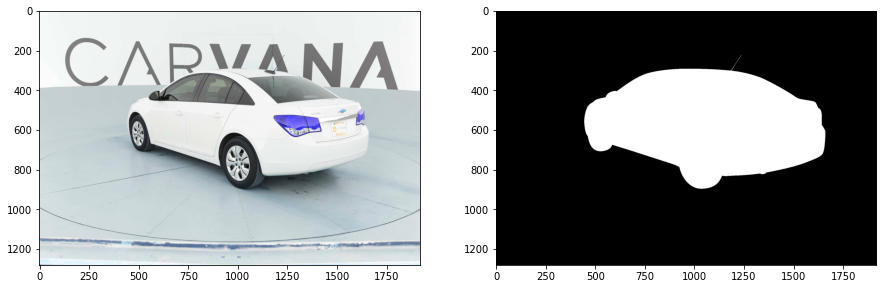

In [10]:
fig=plt.figure(figsize=(15, 15))
image_index = random.choice(range(1,5))
train_image = glob.glob('./train/*')[image_index]
img=cv2.imread(train_image)
mask=Image.open('./train_masks/'+train_image[8:-4]+'_mask.gif')

files=[img,mask]
for i in range(len(files)):
    plt.subplot(1, 2 , i+1)
    plt.imshow(files[i])

# again run this cell for new image

In [11]:
# shape of the image data and masked data
img.shape,image.img_to_array(mask).shape

((1280, 1918, 3), (1280, 1918, 1))

In [12]:
# function to preprocess image
def preprocess_image(img,mask,train=True):
  # fix size of image
  input_img=cv2.resize(img,(128,128))/255.0
  input_mask=cv2.resize(mask,(128,128))
  return input_img,input_mask

  
# function for loading the image
def load_imgs(name):
  input_img = cv2.imread('./train/'+name+'.jpg')
  input_mask = image.img_to_array(Image.open('./train_masks/'+name+'_mask.gif'))
  input_img,input_mask = preprocess_image(input_img,input_mask)
  return input_img,input_mask

In [13]:
def get_train_test_data(imgs_path, test_size=0.8):
  x_data=[]
  y_data=[]
  for i in range(len(imgs_path)):
    input_img,input_mask=load_imgs(imgs_path[i][8:-4])
    x_data.append(input_img)
    y_data.append(input_mask)

  x_d=np.array(x_data)
  y_d=np.array(y_data)
  train_data=int((x_d.shape[0]*test_size))
  x_train=x_d[:train_data]
  y_train=y_d[:train_data]
  x_test=x_d[train_data:]
  y_test=y_d[train_data:]
  return x_train,y_train,x_test,y_test

In [14]:
imgs_path=glob.glob('./train/*')
x_train,y_train,x_test,y_test = get_train_test_data(imgs_path)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

# add a new axis for masked data
y_train=y_train[...,np.newaxis]
y_test=y_test[...,np.newaxis]
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)

(4070, 128, 128, 3) (4070, 128, 128) (1018, 128, 128, 3) (1018, 128, 128)
(4070, 128, 128, 3) (4070, 128, 128, 1) (1018, 128, 128, 3) (1018, 128, 128, 1)


Use MobileNetV2 for Downsampling with imagenet weights 

In [15]:
from tensorflow.keras.applications import MobileNetV2

In [16]:
# Number of output channels
OUTPUT_CHANNELS = 2

**Build Complete Network**

In [17]:
base_model = MobileNetV2(input_shape=(128,128,3),weights = 'imagenet',include_top = False)

# Use the activations of these layers
layer_names = [
               'block_1_expand_relu',   # 64x64
               'block_3_expand_relu',   # 32x32
               'block_6_expand_relu',   # 16x16
               'block_13_expand_relu',  # 8x8
               'block_16_project',      # 4x4
               ]

layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_sampling = tf.keras.Model(inputs=base_model.input, outputs=layers)

# freeze the imagenet weights in downsampling network
down_sampling.trainable = False

9412608/9406464 [==============================] - 0s 0us/step


In [18]:
# summary of downsampling network
#down_sampling.summary()

In [19]:
# create upsampling network
initializer = tf.random_normal_initializer(0., 0.02)
# 4x4 -> 8x8
up_sampling1 = tf.keras.Sequential()
up_sampling1.add(tf.keras.layers.Conv2DTranspose(512,3,
                                                 strides=2,padding='same',
                                                 kernel_initializer=initializer,use_bias=False))
up_sampling1.add(tf.keras.layers.BatchNormalization())
up_sampling1.add(tf.keras.layers.ReLU())


# 8x8 -> 16x16
up_sampling2 = tf.keras.Sequential()
up_sampling2.add(tf.keras.layers.Conv2DTranspose(256,3,
                                                 strides=2,padding='same',
                                                 kernel_initializer=initializer,use_bias=False))
up_sampling2.add(tf.keras.layers.BatchNormalization())
up_sampling2.add(tf.keras.layers.ReLU())

# 16x16 -> 32x32
up_sampling3 = tf.keras.Sequential()
up_sampling3.add(tf.keras.layers.Conv2DTranspose(128,3,
                                                 strides=2,padding='same',
                                                 kernel_initializer=initializer,use_bias=False))
up_sampling3.add(tf.keras.layers.BatchNormalization())
up_sampling3.add(tf.keras.layers.ReLU())

# 32x32 -> 64x64
up_sampling4 = tf.keras.Sequential()
up_sampling4.add(tf.keras.layers.Conv2DTranspose(64,3,
                                                 strides=2,padding='same',
                                                 kernel_initializer=initializer,use_bias=False))
up_sampling4.add(tf.keras.layers.BatchNormalization())
up_sampling4.add(tf.keras.layers.ReLU())

# combine them till before the last layer
up_sampling = [up_sampling1, up_sampling2, up_sampling3, up_sampling4]

In [20]:
# Now combine the downsampling and upsampling network
inputs = tf.keras.layers.Input(shape=[128,128,3])
x = inputs

# Downsampling through the model
skips = down_sampling(x)
x = skips[-1]
print(x.shape)
skips = reversed(skips[:-1])

# Upsampling and establishing the skip connections
for up, skip in zip(up_sampling, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])


# This is the last layer of the model
last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3, strides=2,padding='same')  #64x64 -> 128x128

x = last(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

(None, 4, 4, 320)


In [21]:
# Define Compilation of the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Visualize complete architecture of Network

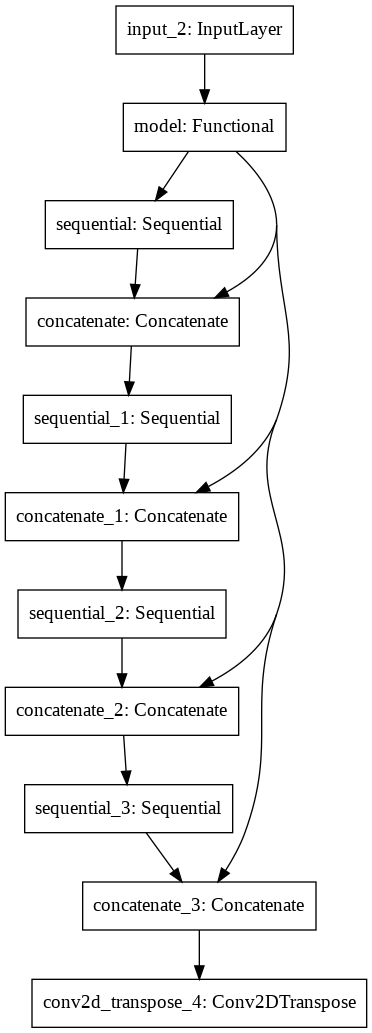

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model)

**Training of the Model**

In [23]:
model_history = model.fit(x_train,y_train, epochs=5,validation_data=(x_test,y_test))

Epoch 1/5
128/128 [==============================] - 19s 75ms/step - loss: 0.1786 - accuracy: 0.9187 - val_loss: 0.0339 - val_accuracy: 0.9866
Epoch 2/5
128/128 [==============================] - 8s 64ms/step - loss: 0.0288 - accuracy: 0.9884 - val_loss: 0.0455 - val_accuracy: 0.9812
Epoch 3/5
128/128 [==============================] - 8s 65ms/step - loss: 0.0226 - accuracy: 0.9904 - val_loss: 0.0271 - val_accuracy: 0.9880
Epoch 4/5
128/128 [==============================] - 8s 65ms/step - loss: 0.0200 - accuracy: 0.9913 - val_loss: 0.0201 - val_accuracy: 0.9912
Epoch 5/5
128/128 [==============================] - 8s 65ms/step - loss: 0.0189 - accuracy: 0.9916 - val_loss: 0.0191 - val_accuracy: 0.9914


Prediction on the test image

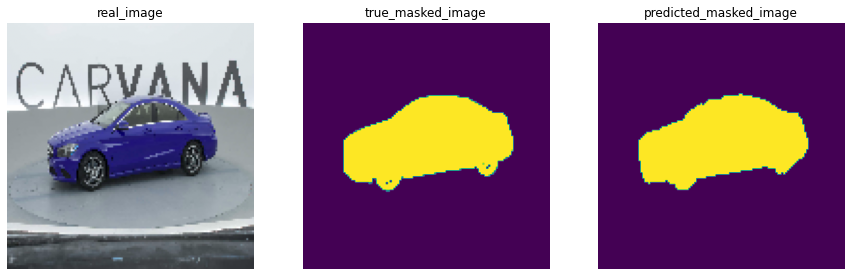

In [24]:
# prediction for any random image of test set
i = random.choice(range(0,x_test.shape[0]))
pred_mask = model.predict(x_test[i:i+1])
# get max value index
y_pred = np.argmax(pred_mask[0],axis = -1)
y_pred = y_pred[...,np.newaxis]

fig = plt.figure(figsize=(15, 15))
img = x_test[i]
true_mask=tf.keras.preprocessing.image.array_to_img(y_test[i])
pred_mask=tf.keras.preprocessing.image.array_to_img(y_pred)
files=[img,true_mask,pred_mask]
label = ['real_image','true_masked_image','predicted_masked_image']
for i in range(len(files)):
    plt.subplot(1, len(files) , i+1)
    plt.axis('Off')
    plt.imshow((files[i]))
    plt.title(label[i])